# Introduction to Convolution Neural Networks and Computer Vision with TensorFlow

Computer Vision is the practice of writing algorithms which can discover in visual data. Such as the camera if a self driving car recognizing a car in front

## Get the data

The images we're working with are from Food101 dataset: (101 different classes of food ): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classses (pizza🍕 and steak🧆)


**NOTE:** We start with a smaller dataset so we can experiment quickly and figure what works(or better yet what doesn't) before scaling up

In [1]:
import zipfile

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

## Inspect the data (become one with it)

A very crucial step at the begining of any machine learning project is becoming one with the data

And for a computer vision project... this usually means visualizing many samples of your data.


In [1]:
ls pizza_steak

 Volume in drive C is Helios
 Volume Serial Number is 8A4B-86A0

 Directory of C:\Users\prash\CODES\TensorFlow\pizza_steak

17-10-2021  15:39    <DIR>          .
17-10-2021  15:39    <DIR>          ..
19-10-2021  11:35             6,148 .DS_Store
17-10-2021  15:39    <DIR>          test
17-10-2021  15:39    <DIR>          train
               1 File(s)          6,148 bytes
               4 Dir(s)  106,620,379,136 bytes free


In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath , dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'pizza_steak'.
There are 2 directories and 1 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 1 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [3]:
# the extra file in our pizza_steak directory is ".DS_Store"
%ls -la pizza_steak

 Volume in drive C is Helios
 Volume Serial Number is 8A4B-86A0

 Directory of C:\Users\prash\CODES\TensorFlow


 Directory of C:\Users\prash\CODES\TensorFlow\pizza_steak

17-10-2021  15:39    <DIR>          .
17-10-2021  15:39    <DIR>          ..
19-10-2021  11:35             6,148 .DS_Store
17-10-2021  15:39    <DIR>          test
17-10-2021  15:39    <DIR>          train
               1 File(s)          6,148 bytes
               4 Dir(s)  106,620,379,136 bytes free


File Not Found


In [4]:
# Another way to find out how many images are in a file
run_steak_image_train = len(os.listdir("pizza_steak/train/steak"))
run_steak_image_train

750

To visualize our images, first let's get the class names progammatically

In [5]:
# Get the classnames progmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) #Create a list of class names from subdirctories
class_names = class_names[1:] # remove .DS_store

In [6]:
 print(class_names)

['pizza' 'steak']


In [7]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup the target directory (we'll view images from here)
    target_folder = target_dir+target_class
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image) #return the list
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0]) #accessing the 0th index of the list ans converting it into string
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    print(random_image[0])
    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

['2587918.jpg']
2587918.jpg
Image shape: (512, 512, 3)


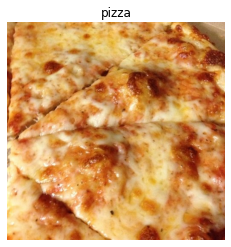

In [8]:
img= view_random_image(target_dir='pizza_steak/train/',
                      target_class='pizza')

🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most preprocessing steps for working with images is to scale(aslo referred to as **normalize**) their pixel values by dividing the image arrays by 255. (Since 255 is the maximum pixel value).

In [9]:
# get all the pixel values between 0 and 1 ( scale/normalize the data, as neural networks love values between 0 and 1)
img/255. 

array([[[0.76862745, 0.58039216, 0.29019608],
        [0.78039216, 0.59215686, 0.30196078],
        [0.78039216, 0.59607843, 0.32156863],
        ...,
        [0.78039216, 0.63921569, 0.51372549],
        [0.78039216, 0.63921569, 0.51372549],
        [0.75686275, 0.61568627, 0.49019608]],

       [[0.78039216, 0.59215686, 0.30196078],
        [0.79215686, 0.60392157, 0.32156863],
        [0.79215686, 0.60784314, 0.33333333],
        ...,
        [0.78823529, 0.64705882, 0.52156863],
        [0.78823529, 0.64705882, 0.52156863],
        [0.76470588, 0.62352941, 0.49803922]],

       [[0.78431373, 0.59607843, 0.31372549],
        [0.79607843, 0.60784314, 0.3254902 ],
        [0.79607843, 0.61176471, 0.3372549 ],
        ...,
        [0.78431373, 0.64313725, 0.51764706],
        [0.78823529, 0.64705882, 0.52156863],
        [0.76862745, 0.62745098, 0.50196078]],

       ...,

       [[0.84705882, 0.38039216, 0.05882353],
        [0.86666667, 0.4       , 0.07843137],
        [0.88627451, 0

## An end-to-end example 

let's build a convolution neural networks to find patterns in our images, more specifically we need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all the pixel values between 0 and 1, aslo called scaling/normalize)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Set up path to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (224, 224),
                                              class_mode ="binary",
                                              seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode="binary",
                                               seed =42)

# Build a CNN model (🔗 : https://poloclub.github.io/cnn-explainer/)
model_1= tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation = 'relu',
                           input_shape = (224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation ='relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding ="valid"),
    tf.keras.layers.Conv2D(10, 3, activation ='relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Complie the model
model_1.compile ( loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                       epochs =5,
                       steps_per_epoch=len(train_data),
                       validation_data = valid_data,
                       validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 18s 202ms/step - loss: 0.5687 - accuracy: 0.7007 - val_loss: 0.4233 - val_accuracy: 0.8120
Epoch 2/5
47/47 [==============================] - 6s 126ms/step - loss: 0.4273 - accuracy: 0.8187 - val_loss: 0.3527 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 6s 131ms/step - loss: 0.4025 - accuracy: 0.8287 - val_loss: 0.3379 - val_accuracy: 0.8680
Epoch 4/5
47/47 [==============================] - 6s 132ms/step - loss: 0.3572 - accuracy: 0.8493 - val_loss: 0.3126 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 7s 151ms/step - loss: 0.3348 - accuracy: 0.8660 - val_loss: 0.3060 - val_accuracy: 0.8720


🔑**Note:** If the above cell is taking longer than ~10 seconds per epoch, make sure you're using a GPU

In [11]:
len(train_data), 1500/32

(47, 46.875)

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

## Using the same mdoel as before

Let's replicate the model we've built in a previous section to see if it works with our image data.

The model we're building is from the [Tensorflow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.33390&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
 

In [13]:
# Set the random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape =(224, 224, 3)),
    tf.keras.layers.Dense(4, activation ='relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')    
])

# Compile the model
model_2.compile( loss = 'binary_crossentropy',
                optimizer =tf.keras.optimizers.Adam(),
                metrics =['accuracy'])
# Fit the model
history_2 = model_2.fit(train_data,
                       epochs =5,
                       steps_per_epoch =len(train_data),
                       validation_data = valid_data,
                        validation_steps = len(valid_data)
                       )

Epoch 1/5
47/47 [==============================] - 7s 136ms/step - loss: 1.3737 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 120ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 137ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 7s 158ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 8s 165ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [14]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more parameters than our CNN (model_1), mdoel_2 performs terribly... let's tyr to improve it

In [15]:
# Set the random seed
tf.random.set_seed(42)

# Create the mdoel
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation ='relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

# Complie the model
model_3.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# fit the model
history_3 = model_3.fit(train_data,
                    epochs =5,
                       steps_per_epoch =len(train_data),
                       validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 196ms/step - loss: 3.0144 - accuracy: 0.6173 - val_loss: 0.6632 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 8s 163ms/step - loss: 1.1050 - accuracy: 0.6773 - val_loss: 0.7373 - val_accuracy: 0.7080
Epoch 3/5
47/47 [==============================] - 8s 180ms/step - loss: 0.8796 - accuracy: 0.7027 - val_loss: 1.3344 - val_accuracy: 0.5880
Epoch 4/5
47/47 [==============================] - 11s 245ms/step - loss: 0.6465 - accuracy: 0.7393 - val_loss: 0.4495 - val_accuracy: 0.7940
Epoch 5/5
47/47 [==============================] - 11s 235ms/step - loss: 0.5408 - accuracy: 0.7480 - val_loss: 0.4760 - val_accuracy: 0.7580


In [16]:
# Get a summmary of model_3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


In [17]:
# This mdoel has approx 500 times more parameters train than our previous model
15000000/31000

483.8709677419355

🔑 **Note:** You can think of trainable parameter as **patterns a model can leran from data.** Intuitivelly, you might think more is better. And in lots of cases, it is. But in this case, the difference here is the too different styles of model we're using. where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolution neural networks seeks to sort out and learn the most important patterns in an image.** So event though these are learnable parameters in our convolution neural networks, these are often more helpful in dechiphering between different **features** in an image.

## Binary Classification: Let's break it down

1. Become one with our data (visualize, visualize, visulaize)
2. Preprocess the data (Prepared it for our model, the main step here was scaling/normalizing & turing our data into batches)
3. Created a mdoel (strat with a baseline)
4. Fit the model.
5. Evaluate the model
6. Adjust the parameters and improve the model(try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)



### 1. Visualize data

['2927833.jpg']
2927833.jpg
Image shape: (384, 512, 3)
['1593835.jpg']
1593835.jpg
Image shape: (384, 512, 3)


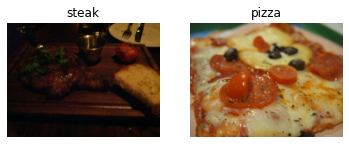

In [18]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/" , "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

## Preprocess the data(prepare it for the model)

In [19]:
# Define the directory paths

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time. 
It does this for a couple of reasons:
1. 10,000 images(or more)might not fit into the memory of your processor(GPU).
2. Tyring to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

In [20]:
!nvidia-smi

Tue Oct 19 21:31:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P3    15W /  N/A |   3014MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255.)
valid_datagen = ImageDataGenerator(rescale = 1/255.) 

In [22]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,  # target directory of images
                                                target_size = (224, 224),  # target size of images(height, width)
                                                class_mode = "binary", # type of data you are working with
                                                batch_size =32) # size of minibatches to load data into
test_data = valid_datagen.flow_from_directory(directory = test_dir,
                                                 target_size = (224, 224),
                                                 class_mode = "binary",
                                                 batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [23]:
# Get a sample of train data batch 
images, labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [24]:
# How many batches are there?
len(train_data), 1500/32

(47, 46.875)

In [25]:
# Get the first two images
images[:2], images[0].shape, images[7].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [26]:
# view the first batch of labels 
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a CNN model(start with a baseline)

A basline is a realatively simple model or existing result that you steup when begining a machine learning experiment and then as you experimenting, you try to beat the baseline model

> 🔑 **Note** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem)

In [27]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Create the model (this will be our baseline, a layer convolution neural network)
model_4 = Sequential ([
    Conv2D(filters =10, # Decides how many filters should pass over an input image, it is the number of sliding windows going across input. (Higher means more complex model) 
        kernel_size = 3,
        strides = 1,
        padding = "valid", # If "same", Output shape is same as input shape, if "valid", output shape gets compressed
        activation ="relu",
        input_shape = (224, 224, 3)), # input layer specify input shape
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    Flatten(),
    Dense(1, activation = 'sigmoid') # output layer (working with the binary classification so only 1 output neuron)
])



In [28]:
# Compile the model
model_4.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics = ['accuracy'])

In [29]:
# Get a summary of our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Check the length of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [31]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and samples
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 15s 283ms/step - loss: 1.4832 - accuracy: 0.6633 - val_loss: 0.4522 - val_accuracy: 0.8080
Epoch 2/5
47/47 [==============================] - 13s 283ms/step - loss: 0.4508 - accuracy: 0.8020 - val_loss: 0.3929 - val_accuracy: 0.8260
Epoch 3/5
47/47 [==============================] - 12s 262ms/step - loss: 0.3444 - accuracy: 0.8693 - val_loss: 0.3768 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 12s 259ms/step - loss: 0.1903 - accuracy: 0.9333 - val_loss: 0.4934 - val_accuracy: 0.7720
Epoch 5/5
47/47 [==============================] - 13s 282ms/step - loss: 0.0855 - accuracy: 0.9800 - val_loss: 0.5223 - val_accuracy: 0.8080


### 5. Evaluating our model

It looks like our model is learing something, let's evaluate it.

<AxesSubplot:>

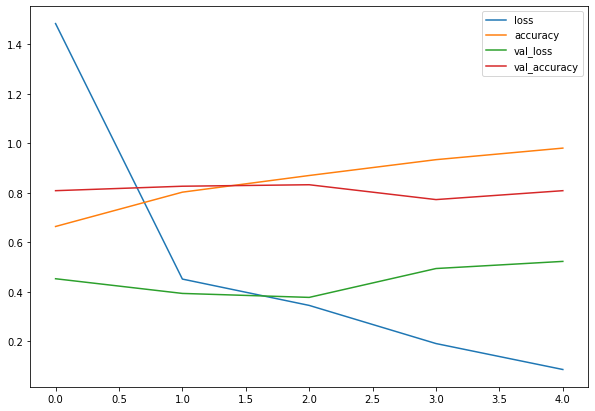

In [32]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize =(10,7))

In [33]:
# Plot the validation and training curves separetly
def plot_loss_curves(history):
    """
    Returns seperate loss curves for training and validation metrics.
    
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"])) # how many epochs did we run for
     
    #plot loss
    plt.figure()
    plt.plot(epochs, loss, label ="training loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    
     #plot loss
    plt.figure()
    plt.plot(epochs, accuracy, label ="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    

> 🔑 **Note:** when a mdoel's **validation loss starts to increase**, it's likely that the model is **overfitting** the training dataset. This means, it's learining the patterns in the trainin g dataset **too well** and thus the model's ability to generalize to unseen data will be diminished. 

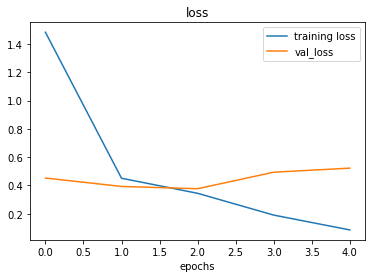

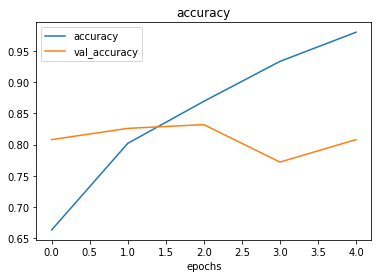

In [34]:
# chehck the loss and accuracy
plot_loss_curves(history_4)

> 🔑 **Note:** Ideally the two losses curves (taining and validation) will be very similar to each other decresing at similar rates, when there are large difference your model may be **overfittig** 

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:
1. Create a baseline
2. Beat the baseline by overfitting a larger model
3. reduce the overfitting

* Ways the number of conv layers 
* Increase the number of conv layers 
* Increase the number of filters
* Add another dense layers to the output of our flatten layer

Reduce overfitting 
* Add data agumentation
* Add regularization (such as MaxPool2D)
* Add more data

> 🔑**Note:** Reducing is overfitting is also known as regularization.


In [35]:
# Create the mdoel (this is going to our new baseline)
model_5 = Sequential([
    Conv2D(10, 3, activation ="relu", input_shape = (224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation ="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation ="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation ='sigmoid')
    
])

# Compile the mdoel
model_5.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics = ['accuracy'])

# Fit the model

history_5 = model_5.fit(train_data,
                       steps_per_epoch = len(train_data),
                       epochs=10,
                       validation_data = test_data,
                       validation_steps =len(test_data))

Epoch 1/10
47/47 [==============================] - 14s 269ms/step - loss: 0.6579 - accuracy: 0.6100 - val_loss: 0.5317 - val_accuracy: 0.7240
Epoch 2/10
47/47 [==============================] - 12s 254ms/step - loss: 0.4662 - accuracy: 0.7887 - val_loss: 0.3745 - val_accuracy: 0.8500
Epoch 3/10
47/47 [==============================] - 12s 256ms/step - loss: 0.4313 - accuracy: 0.8140 - val_loss: 0.4103 - val_accuracy: 0.8000
Epoch 4/10
47/47 [==============================] - 11s 230ms/step - loss: 0.4292 - accuracy: 0.8240 - val_loss: 0.3584 - val_accuracy: 0.8580
Epoch 5/10
47/47 [==============================] - 12s 256ms/step - loss: 0.3832 - accuracy: 0.8313 - val_loss: 0.3292 - val_accuracy: 0.8640
Epoch 6/10
47/47 [==============================] - 12s 248ms/step - loss: 0.3586 - accuracy: 0.8433 - val_loss: 0.3243 - val_accuracy: 0.8700
Epoch 7/10
47/47 [==============================] - 11s 230ms/step - loss: 0.3533 - accuracy: 0.8480 - val_loss: 0.3267 - val_accuracy: 0.8660

In [36]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

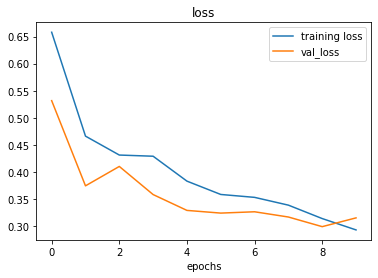

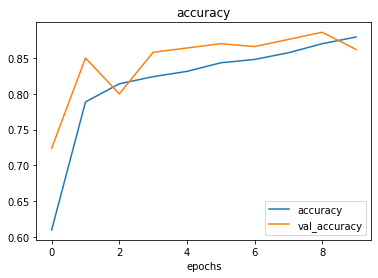

In [37]:
# Plot the loss curves
plot_loss_curves(history_5)

## Opeaning our bags of tricks and finding data augmentation

In [38]:
# Create ImageDataGenerator training instances with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale =1/255.,
                                         rotation_range = 0.2,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.3,
                                         horizontal_flip = True)

# Create ImageDataGenerator without data augmentation for the train datset
train_datagen = ImageDataGenerator(rescale = 1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale =1/255.)

>🤔 **Question:** What is data augmentation?
    
Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns.Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. 
    
Let's write some code to visualize data augmentation..

In [39]:
# Import data and augment it from training directory
print('Agumented training data')
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                    target_size =(224, 224),
                                                                    batch_size = 32,
                                                                    class_mode = "binary",
                                                                    shuffle = False ) 
                                                                

# Create non-augumented train data batches
print("Non-augumented training data")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size =(224, 224),
                                                batch_size = 32,
                                                class_mode = "binary",
                                                shuffle = False)
    
# Create non-augmented test data batch 
print('Non-augmented test data')
test_data  = test_datagen.flow_from_directory(test_dir,
                                              target_size =(224, 224),
                                              batch_size = 32,
                                              class_mode = 'binary',
                                              shuffle  = False)


Agumented training data
Found 1500 images belonging to 2 classes.
Non-augumented training data
Found 1500 images belonging to 2 classes.
Non-augmented test data
Found 500 images belonging to 2 classes.


>🔑**Note:** Data agumentation is usually only preforms on the training data. Using `ImageDataGenerator` built-in data agumentation parameters our images are left as they are in the directories but are modified as they're loaded into the model.
* Labels aren't augmented
Finally... let's visualize some augmented data!!!

In [40]:
# Get the data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() #note:labels aren't augmented...only data (images)


showing image number: 23


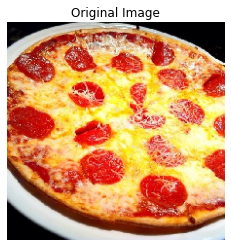

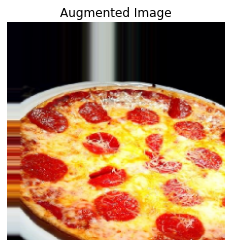

In [41]:
# Show the original image and augmented image
import random
random_number = random.randint(0, 32) # our batch sizes are 32..
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented Image")
plt.axis(False);

Now we've seen what augmented training data looks like, let's build and see how it learns

In [42]:
# Create a model (same as model_5 )
model_6 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
    MaxPool2D(pool_size =2),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation ='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

# Compile the mdoel
model_6.compile( loss= 'binary_crossentropy',
               optimizer = Adam(),
               metrics =['accuracy'])

# fit the model
history_6 = model_6.fit(train_data_augmented,
                       epochs = 5,
                       steps_per_epoch = len(train_data_augmented),
                       validation_data = test_data,
                       validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 25s 525ms/step - loss: 0.7163 - accuracy: 0.4640 - val_loss: 0.6784 - val_accuracy: 0.5180
Epoch 2/5
47/47 [==============================] - 23s 488ms/step - loss: 0.6902 - accuracy: 0.5427 - val_loss: 0.6656 - val_accuracy: 0.5280
Epoch 3/5
47/47 [==============================] - 25s 541ms/step - loss: 0.6810 - accuracy: 0.5733 - val_loss: 0.5803 - val_accuracy: 0.7820
Epoch 4/5
47/47 [==============================] - 25s 533ms/step - loss: 0.6600 - accuracy: 0.6387 - val_loss: 0.5700 - val_accuracy: 0.6720
Epoch 5/5
47/47 [==============================] - 23s 483ms/step - loss: 0.6112 - accuracy: 0.6947 - val_loss: 0.6622 - val_accuracy: 0.6740


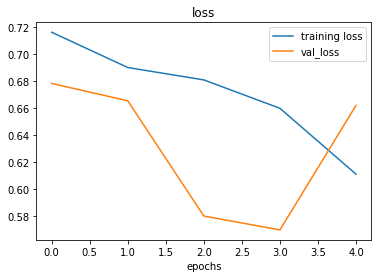

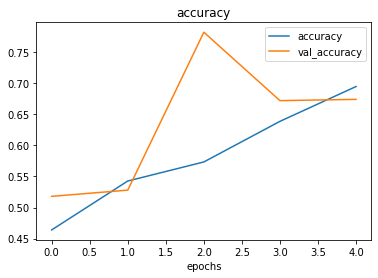

In [43]:
# check our models training curves
plot_loss_curves(history_6)

>Let's shuffle our augmented training data and train another model(the same as before)on it and see what happens.

In [44]:
# Import data and augment it and shuffle from directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                         target_size = (224, 224),
                                                                         batch_size= 32,
                                                                         class_mode = "binary",
                                                                         shuffle = True) #shuffle data this time



Found 1500 images belonging to 2 classes.


In [45]:
# Create the model (same as model_5 adn model_6)
model_7 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape =(224, 224, 3)),
    MaxPool2D(pool_size =2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

# compile the model
model_7.compile(loss = 'binary_crossentropy',
               optimizer = Adam(),
               metrics = ['accuracy'])

# Fit the model on the augmented shffled training data
hisory_7 = model_7.fit(train_data_augmented_shuffled,
                      epochs = 10,
                      steps_per_epoch = len(train_data_augmented_shuffled),
                      validation_data = test_data,
                      validation_steps = len(test_data))

Epoch 1/10
47/47 [==============================] - 26s 554ms/step - loss: 0.6637 - accuracy: 0.6067 - val_loss: 0.5918 - val_accuracy: 0.7200
Epoch 2/10
47/47 [==============================] - 22s 470ms/step - loss: 0.5853 - accuracy: 0.6860 - val_loss: 0.5173 - val_accuracy: 0.7140
Epoch 3/10
47/47 [==============================] - 27s 579ms/step - loss: 0.5508 - accuracy: 0.7233 - val_loss: 0.3981 - val_accuracy: 0.8320
Epoch 4/10
47/47 [==============================] - 25s 524ms/step - loss: 0.4973 - accuracy: 0.7640 - val_loss: 0.3961 - val_accuracy: 0.8240
Epoch 5/10
47/47 [==============================] - 27s 586ms/step - loss: 0.5086 - accuracy: 0.7473 - val_loss: 0.4145 - val_accuracy: 0.8140
Epoch 6/10
47/47 [==============================] - 24s 513ms/step - loss: 0.4971 - accuracy: 0.7687 - val_loss: 0.3611 - val_accuracy: 0.8500
Epoch 7/10
47/47 [==============================] - 22s 467ms/step - loss: 0.4697 - accuracy: 0.7787 - val_loss: 0.3897 - val_accuracy: 0.8120

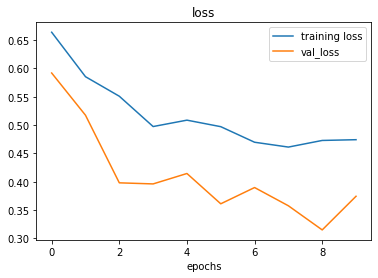

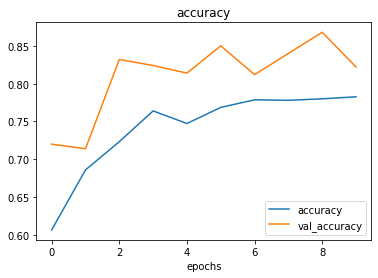

In [46]:
plot_loss_curves(hisory_7)

>🔑**Note:** When shuffling training data, the model gets exposed to all different to all different kinds of data during trining, thus enabling it to learn features across a wide array of images(in our case, pizza and steak at the same time instead of just pizza then steak).

### 7. Repeat until satisfied

Since we've already beaten the baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more `Conv2D`/`MaxPool2D` layers)
* Increase the number of filters in each convolution layer (e.g. from 10 to 32 or even 64)
* Trian for longer (more epochs)
* Find an ideal learing rate
* Get more data(give the model more opportunities to learn)
* Use **Transfer Learning** to levrage what another image model has learn and adjust it for our own use case.



## Making a prediction with our trained mdoel on our custom data

In [47]:
# Classes we are woring with 
print(class_names)

['pizza' 'steak']


In [48]:
# View our example image
steak = mpimg.imread("steak_1.jpg")

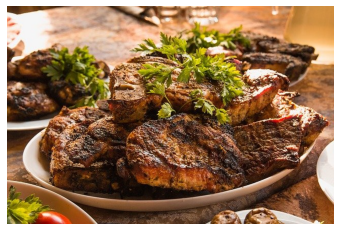

In [49]:
plt.imshow(steak)
plt.axis(False);

In [50]:
steak.shape

(426, 640, 3)

> 🔑**Note:** When you train a neural network and you want to make a prediction with it on your custom data(or new data) is preprocessed into the same format as the data your model was trained on. 

In [51]:
expanded_steak = tf.expand_dims(steak, axis = 0)

In [52]:
#Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename , img_shape=224):
    """
    Reads an image from filenames, turns it into a tensor and reshapes it 
    to (img_shape, colour_channels).
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the read file into the tensor 
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    # Rescale the iamge ( get all the values between 0 and 1)
    img = img/255.
    return img

In [53]:
# Load in and preprocess our custom image
steak = load_and_prep_image('steak_1.jpg')
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.35970265, 0.19600089, 0.05710409],
        [0.3310099 , 0.18223664, 0.05759804],
        [0.2975503 , 0.15864721, 0.05782313],
        ...,
        [0.8117647 , 0.5647059 , 0.2509804 ],
        [0.80784315, 0.5647059 , 0.23921569],
        [0.80784315, 0.5647059 , 0.23921569]],

       [[0.35714284, 0.20028012, 0.06302521],
        [0.34056625, 0.19667117, 0.07330433],
        [0.2932773 , 0.16498598, 0.06414566],
        ...,
        [0.8117647 , 0.5647059 , 0.2509804 ],
        [0.80784315, 0.5647059 , 0.23921569],
        [0.80784315, 0.5647059 , 0.23921569]],

       [[0.35714284, 0.20028012, 0.06302521],
        [0.34223065, 0.1981155 , 0.07804997],
        [0.29819676, 0.16990545, 0.06906512],
        ...,
        [0.8117647 , 0.5647059 , 0.2509804 ],
        [0.80784315, 0.5647059 , 0.23921569],
        [0.80784315, 0.5647059 , 0.23921569]],

       ...,

       [[0.4000286 , 0.4353227 , 0.21378902],
        [0.41

In [54]:
# Let's predict
pred = model_7.predict(tf.expand_dims(steak, axis=0))

Looks like our custom image is being put through our model, however, it currently outputs a prediction probability, wouldn't it be nice if we could visualize the image as well as model's predictions

In [55]:
# remind ourselves of our class name
class_names

array(['pizza', 'steak'], dtype='<U9')

In [56]:
# we can index the predicted class by rounding the prediction probability and indenxing it on the class names
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [57]:
def pred_and_plot(model, filename, class_names = class_names):
    """
    Import an image located at filenames, makes a prdiction with model 
    and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    pred_class = class_names[int(tf.round(pred))]
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

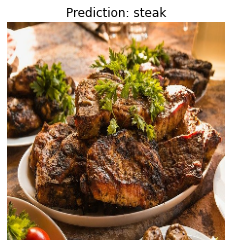

In [58]:
# Test our model on custom image
pred_and_plot(model_7, "steak_1.jpg")

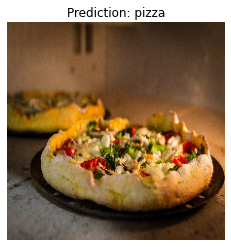

In [70]:
pred_and_plot(model_7, "pizza_3.jpg")

# Multi-class Image Classification

We've just been through a bunch of the following steps with a binary classification problem (pizza vs. steak), now we're going to step things up notch with 10 classes of food ( multi-class classification)
1. Become one with the data
2. Preprocess the data (get it ready for a mdoel)
3. Create a model (start with the baseline )
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Ajust different hyperparameters and improve the model (try to beat baseline/reduce overfittng)
7. Repeat until satisfied

### Become one with the data

In [60]:
import os

# Walk though the 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data\test'
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'
There are 10 directori

In [61]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [62]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


['1612638.jpg']
1612638.jpg
Image shape: (512, 512, 3)


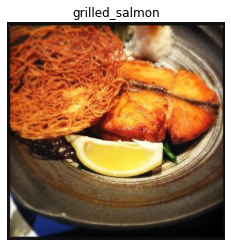

In [63]:
# Visualize, visualize and visualize
img = view_random_image(target_dir= train_dir,
                        target_class = random.choice(class_names))  

### 2. Preprocess the data(prepare it for a model)

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Load data in form directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = "categorical",
                                               shuffle = True)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size =(224, 224),
                                             batch_size = 32,
                                             class_mode = "categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [65]:
### 3. Create a model (start with the baseline)
model_8 = Sequential([
    Conv2D(10, 3, input_shape = (224, 224, 3)),
    Activation("relu"),
    Conv2D(10, 3, activation ='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation ="relu"),
    Conv2D(10, 3, activation ="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation ='sigmoid')
    
])

# Compile the model 
model_8.compile( loss ='binary_crossentropy',
                optimizer = Adam(),
                metrics =['accuracy'])

# Fit the model
history_8 =model_8.fit(train_data,
                       epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data=test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 49s 209ms/step - loss: 0.3198 - accuracy: 0.1923 - val_loss: 0.3002 - val_accuracy: 0.2568
Epoch 2/5
235/235 [==============================] - 39s 168ms/step - loss: 0.2906 - accuracy: 0.3063 - val_loss: 0.2858 - val_accuracy: 0.3288
Epoch 3/5
235/235 [==============================] - 40s 171ms/step - loss: 0.2658 - accuracy: 0.4017 - val_loss: 0.2808 - val_accuracy: 0.3552
Epoch 4/5
235/235 [==============================] - 28s 119ms/step - loss: 0.2265 - accuracy: 0.5340 - val_loss: 0.2962 - val_accuracy: 0.3416
Epoch 5/5
235/235 [==============================] - 23s 96ms/step - loss: 0.1540 - accuracy: 0.7371 - val_loss: 0.3529 - val_accuracy: 0.3076


### 5. Evaluate the model

In [66]:
 # Evaluate on the test data
model_8.evaluate(test_data) 

79/79 [==============================] - 6s 80ms/step - loss: 0.3529 - accuracy: 0.3076


[0.35289400815963745, 0.3075999915599823]

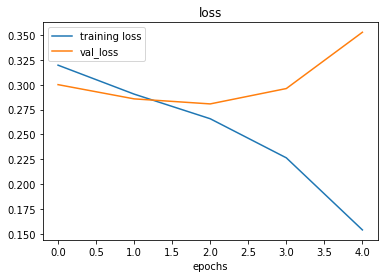

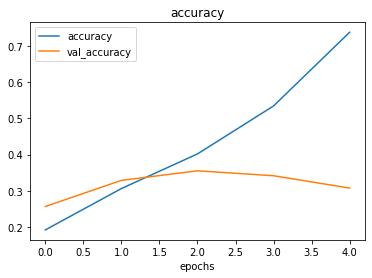

In [67]:
# Check out the model loss curves
plot_loss_curves(history_8)

It seems our model's is **overfitting** the training set quite badly... in other words, it's getting great results on the training data but fails to generalize well to unseen data and perform poorly on the test dataset


### 6. Adjust the model hyperparameter (to beat the baseline/reduce overfitting)

Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So, let's try and fix overfitting by...

* **Get More data**  - having more data gives a model more opportunity to learn diverse patterns..
* **Simply the model** - if our current model is overfitting the data, it may be too complicated of a model, one way to simplify a model is to: reduce # of layers or reduce # hidden units in layers
* **Use Data Augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patterns on your own dataset.


In [71]:
# How about we try and simplify the model first?
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 10)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 53, 53, 10)       

In [72]:
# Let;s try to remove 2 convolution layers..
model_9 = Sequential([
    Conv2D(10, 3, activation = "relu", input_shape = (224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation = 'sigmoid')
    
])

model_9.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics =['accuracy'])
# Fit the model with 2X conv layers removed
history_9 = model_9.fit(train_data,
                       epochs = 5,
                       steps_per_epoch=len(train_data),
                       validation_data= test_data,
                       validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 24s 99ms/step - loss: 0.3408 - accuracy: 0.2156 - val_loss: 0.2871 - val_accuracy: 0.3176
Epoch 2/5
235/235 [==============================] - 24s 103ms/step - loss: 0.2766 - accuracy: 0.3623 - val_loss: 0.2851 - val_accuracy: 0.3116
Epoch 3/5
235/235 [==============================] - 24s 103ms/step - loss: 0.2469 - accuracy: 0.4749 - val_loss: 0.2873 - val_accuracy: 0.3476
Epoch 4/5
235/235 [==============================] - 24s 102ms/step - loss: 0.2054 - accuracy: 0.5987 - val_loss: 0.3084 - val_accuracy: 0.3176
Epoch 5/5
235/235 [==============================] - 24s 102ms/step - loss: 0.1543 - accuracy: 0.7492 - val_loss: 0.3449 - val_accuracy: 0.3120


In [73]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 29160)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                291610    
Total params: 292,800
Trainable params: 292,800
Non-trainable params: 0
________________________________________________

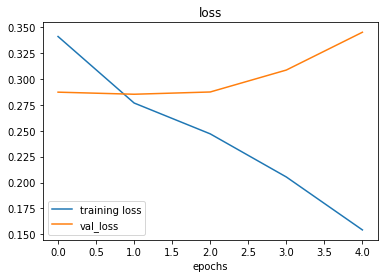

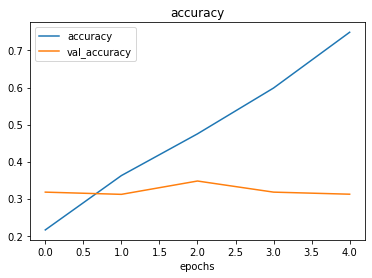

In [74]:
plot_loss_curves(history_9)

Looks like our "simplifying the model" experimnet didn't work..the accuracy went down and overfitting continued...

>How about we try data augmentation?

### Try to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data..
Ideally, we want to:
* Readuce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [76]:
# Create an augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             rotation_range =0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             zoom_range =0.2,
                                             horizontal_flip = True)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224,224),
                                                                  batch_size = 32,
                                                                  class_mode= "categorical",
                                                                  shuffle = True)

Found 7500 images belonging to 10 classes.


In [81]:
#Let's create another model but this time we will fit it on the augmented  training data
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (using the same previous steps)
model_10.compile(loss ="categorical_crossentropy",
                 optimizer= Adam(),
                 metrics = ['accuracy'])

# Fit the model
history_10 = model_10.fit(train_data_augmented ,
                         epochs = 5,
                         steps_per_epoch = len(train_data_augmented),
                         validation_data = test_data,
                         validation_steps = len(test_data))


Epoch 1/5
235/235 [==============================] - 84s 357ms/step - loss: 2.2416 - accuracy: 0.1699 - val_loss: 2.0688 - val_accuracy: 0.2444
Epoch 2/5
235/235 [==============================] - 75s 317ms/step - loss: 2.1124 - accuracy: 0.2344 - val_loss: 2.0056 - val_accuracy: 0.2892
Epoch 3/5
235/235 [==============================] - 72s 308ms/step - loss: 2.0357 - accuracy: 0.2773 - val_loss: 1.8988 - val_accuracy: 0.3276
Epoch 4/5
235/235 [==============================] - 83s 352ms/step - loss: 1.9807 - accuracy: 0.3031 - val_loss: 1.8624 - val_accuracy: 0.3568
Epoch 5/5
235/235 [==============================] - 78s 334ms/step - loss: 1.9404 - accuracy: 0.3205 - val_loss: 1.7918 - val_accuracy: 0.3792


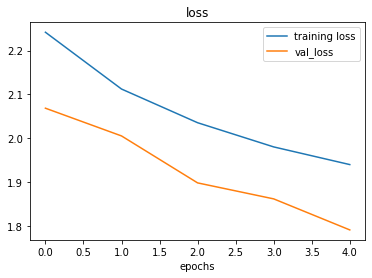

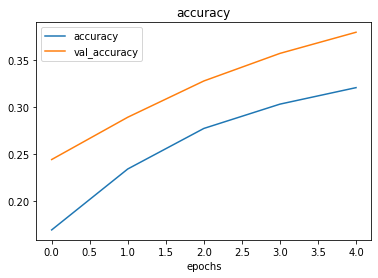

In [82]:
plot_loss_curves(history_10)

In [83]:
model_10.evaluate(test_data)

79/79 [==============================] - 6s 80ms/step - loss: 1.7918 - accuracy: 0.3792


[1.7917513847351074, 0.3792000114917755]

That looks much better, the loss curve are much closer to each other than the basline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

### 7. Repeat until satisfied

We could keep going here... continally trying to bring our loss curves closer together and trying to improve the validation/test accuracy.
  
How?

By running lots of experiments, namely:
- restructuring our model's architecture (increasing layers/ hidden units)
- adjust the learning rate
- try different methods of data augmentation (adjust the hyperparameters in our ImageDataGenerator instance) 
- training for longer (e.g. 10 epochs instead of 5 epochs)
- try **transfer learning**

### Making a prediction with our trained model

Let's use our trained model to make some predictions on our custom images!


In [97]:
list(class_names)

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [104]:
# Reconfig pred_and_plot to work with multi class images
def pred_and_plot(model, filename, class_names = class_names):
    """
    Import an image located at filenames, makes a prdiction with model 
    and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    print(pred)
    
    # Add in logic for multi-class and get pred_class names
    if len(pred[0]>1):
        pred_class = class_names[tf.argmax(pred[0])]
    else:
    # Get the predicted class
        pred_class = class_names[int(tf.round(pred))]

        # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

[[0.17164521 0.12370946 0.29115063 0.24418618 0.3714005  0.33638042
  0.17633116 0.21009652 0.42256576 0.26315734]]


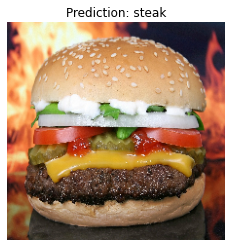

In [113]:
# Make a prediction using model 10
pred_and_plot(model= model_10,
              filename ='hamburgr.jpg',
              class_names = class_names)

Looks like our model didn't perform very well on our custom images but this is because it achieved ~39% accuracy on the test data. So we can expect it to fucntion quite poorly on other unseen data.

## Saving and Loading our model

In [114]:
# Save a model
model_10.save("saved_trained_model_10")

INFO:tensorflow:Assets written to: saved_trained_model_10\assets


In [115]:
# Load in a trained model and evaluate it 
loaded_model_10 = tf.keras.models.load_model('saved_trained_model_10')
loaded_model_10.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 1.7918 - accuracy: 0.3792


[1.7917513847351074, 0.3792000114917755]

In [116]:
# Compare our loaded model to our existing model
model_10.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 1.7918 - accuracy: 0.3792


[1.791751503944397, 0.3792000114917755]